In [45]:
from src.data.image_loaders import AerialCarsImageLoader
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

(24, 52, 3)


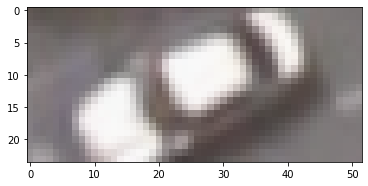

In [46]:
aerialCarsImageLoader = AerialCarsImageLoader()

image = aerialCarsImageLoader.load_image(
    '../../data/raw/aerial-cars-dataset/MOS75.png',
    '../../data/raw/aerial-cars-dataset/MOS75.txt'
)

car = image.get_car(image.bnd_boxes[6])
print(car.shape)
plt.imshow(car)

In [47]:
# car = cv2.copyMakeBorder(car,5,0,5,0,cv2.BORDER_CONSTANT,value=[0,0,0])'
def preprocess(car):
    if car.shape[0] > car.shape[1]:
        car = cv2.rotate(car, cv2.ROTATE_90_CLOCKWISE)
    car = resize(car, (32, 64))
    car = np.float32(car)
    return car

car = preprocess(car)

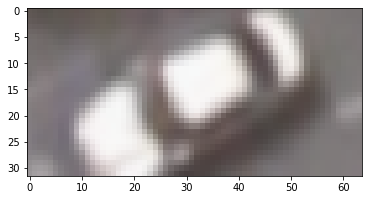

In [48]:
plt.imshow(car)

### HOG

source: https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/

In [49]:
def get_hog(image):
    #resize image
    resized_img = image

    #generating HOG features
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(4, 4),
    cells_per_block=(2, 2), visualize=True, multichannel=True)

    # print('\n\nShape of Image Features\n\n')
    # print(fd.shape)

    return fd, hog_image

In [50]:
fd, hog_image = get_hog(car)

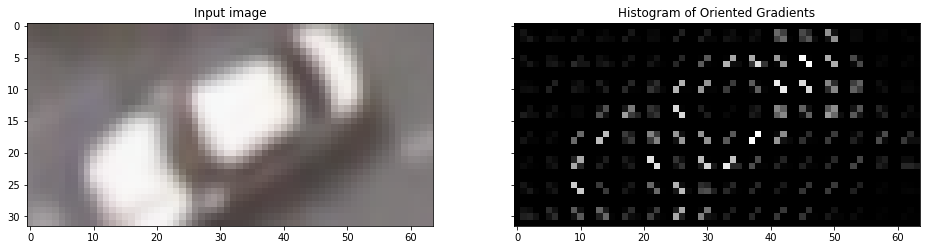

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(car, cmap=plt.cm.gray) 
ax1.set_title('Input image') 

# Rescale histogram for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

### Local binary patterns

In [52]:
# source
# https://www.geeksforgeeks.org/create-local-binary-pattern-of-an-image-using-opencv-python/

def get_pixel(img, center, x, y): 
      
    new_value = 0
      
    try: 
        # If local neighbourhood pixel  
        # value is greater than or equal 
        # to center pixel values then  
        # set it to 1 
        if img[x][y] >= center: 
            new_value = 1
              
    except: 
        # Exception is required when  
        # neighbourhood value of a center 
        # pixel value is null i.e. values 
        # present at boundaries. 
        pass
      
    return new_value 
   
# Function for calculating LBP 
def lbp_calculated_pixel(img, x, y): 
   
    center = img[x][y] 
   
    val_ar = [] 
      
    # top_left 
    val_ar.append(get_pixel(img, center, x-1, y-1)) 
      
    # top 
    val_ar.append(get_pixel(img, center, x-1, y)) 
      
    # top_right 
    val_ar.append(get_pixel(img, center, x-1, y + 1)) 
      
    # right 
    val_ar.append(get_pixel(img, center, x, y + 1)) 
      
    # bottom_right 
    val_ar.append(get_pixel(img, center, x + 1, y + 1)) 
      
    # bottom 
    val_ar.append(get_pixel(img, center, x + 1, y)) 
      
    # bottom_left 
    val_ar.append(get_pixel(img, center, x + 1, y-1)) 
      
    # left 
    val_ar.append(get_pixel(img, center, x, y-1)) 
       
    # Now, we need to convert binary 
    # values to decimal 
    power_val = [1, 2, 4, 8, 16, 32, 64, 128] 
   
    val = 0
      
    for i in range(len(val_ar)): 
        val += val_ar[i] * power_val[i] 
          
    return val 


def get_lbp(image):
    img_bgr = image
    
    height, width, _ = img_bgr.shape 
    
    # We need to convert RGB image  
    # into gray one because gray  
    # image has one channel only. 
    img_gray = cv2.cvtColor(img_bgr, 
                            cv2.COLOR_BGR2GRAY) 
    
    # Create a numpy array as  
    # the same height and width  
    # of RGB image 
    img_lbp = np.zeros((height, width), 
                    np.uint8) 
    
    for i in range(0, height): 
        for j in range(0, width): 
            img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)

    histogram, bin_edges = np.histogram(img_lbp, bins=256, range=(0, 256))

    return histogram, img_lbp 

In [53]:
histogram, img_lbp = get_lbp(car)

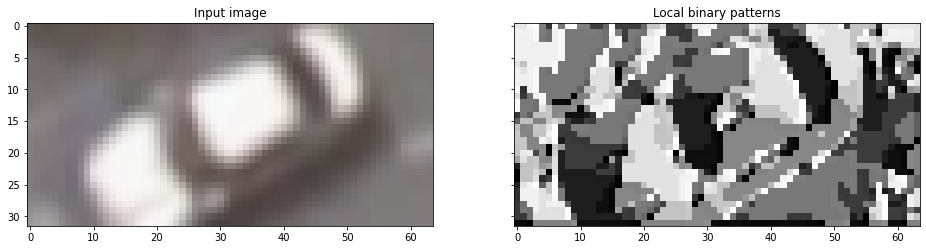

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(car) 
ax1.set_title('Input image') 

ax2.imshow(img_lbp, cmap ="gray") 
ax2.set_title('Local binary patterns')

plt.show()

### Random image

In [55]:
r_img = image.get_random_box(32, 64)
r_img = preprocess(r_img)

Text(0.5, 1.0, 'Local binary patterns')

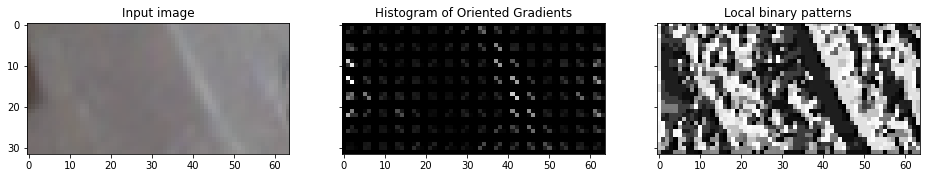

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True) 

ax1.imshow(r_img) 
ax1.set_title('Input image') 

fd, hog_image = get_hog(r_img)
ax2.imshow(hog_image, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients')

histogram, img_lbp = get_lbp(r_img)
ax3.imshow(img_lbp, cmap ="gray") 
ax3.set_title('Local binary patterns')

### Classification

In [57]:
def get_features(img):
    img = preprocess(img)
    hog_f, hog_image = get_hog(img)
    lbp_f, lbp_image = get_lbp(r_img)

    return np.concatenate((hog_f, lbp_f))

In [58]:
DATA_DIR = '../../data/interim/aerial-cars-dataset/'

imgs = []

aerialCarsImageLoader = AerialCarsImageLoader()
for img_name in os.listdir(DATA_DIR):
    if (img_name.endswith('.png') or img_name.endswith('.jpg') or img_name.endswith('.JPG')):
        ann_dir = DATA_DIR+img_name
        ann_dir = ann_dir.replace('.png', '.txt')
        ann_dir = ann_dir.replace('.jpg', '.txt')
        ann_dir = ann_dir.replace('.JPG', '.txt')
        imgs.append(aerialCarsImageLoader.load_image(
            DATA_DIR+img_name,
            ann_dir
        ))

In [59]:
X = []
y = []

for img in tqdm(imgs):
    for bnd_box in img.bnd_boxes:
        car = img.get_car(bnd_box)
        X.append(get_features(car))
        y.append(1)

        r_img = img.get_random_box(32, 64)
        X.append(get_features(r_img))
        y.append(0)

100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


In [60]:
len(y)

628

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [63]:
clf = make_pipeline(SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.03      0.02      0.02       109
           1       0.22      0.31      0.26        99

    accuracy                           0.16       208
   macro avg       0.13      0.17      0.14       208
weighted avg       0.12      0.16      0.14       208



In [65]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       109
           1       0.92      0.99      0.96        99

    accuracy                           0.96       208
   macro avg       0.96      0.96      0.96       208
weighted avg       0.96      0.96      0.96       208



### Validation

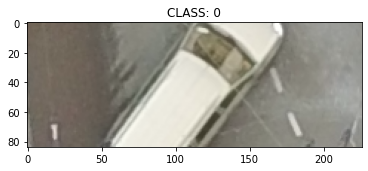

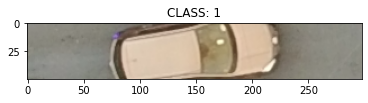

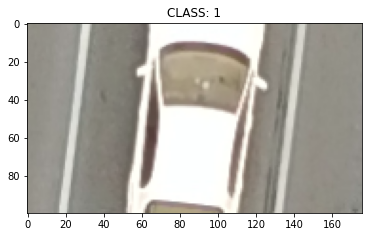

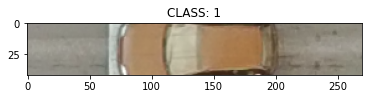

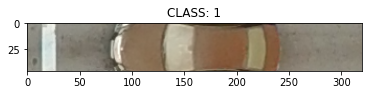

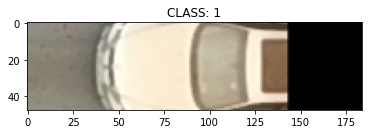

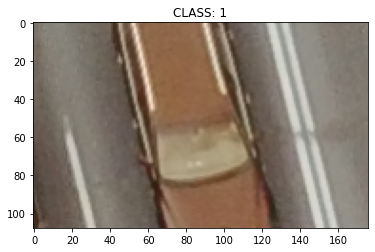

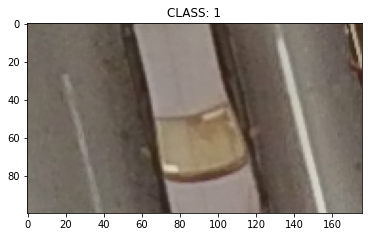

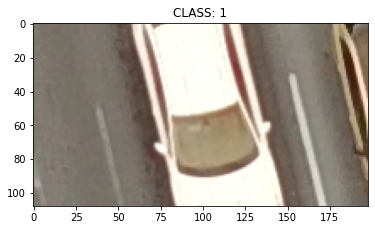

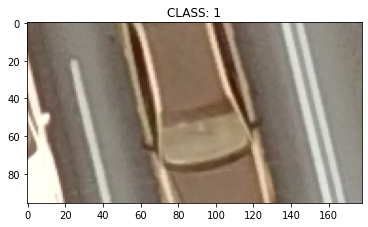

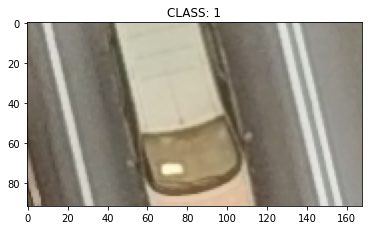

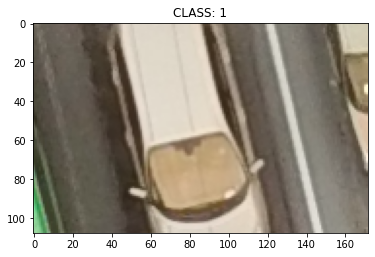

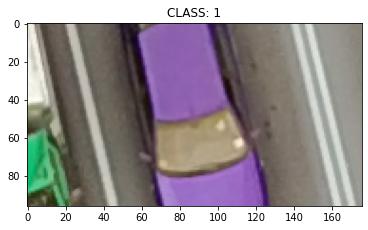

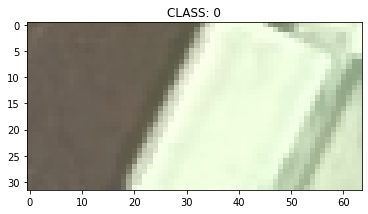

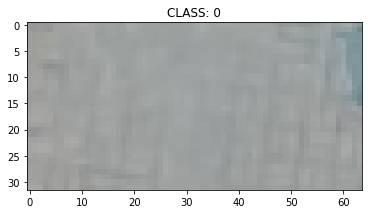

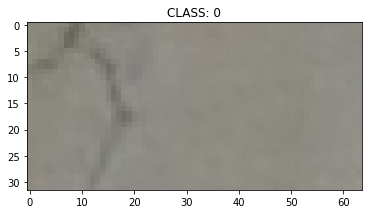

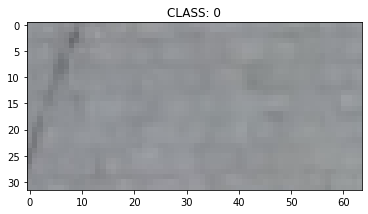

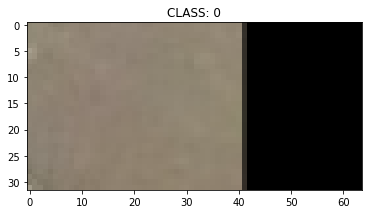

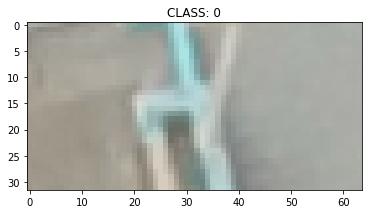

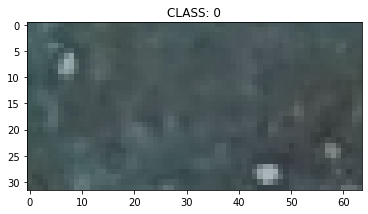

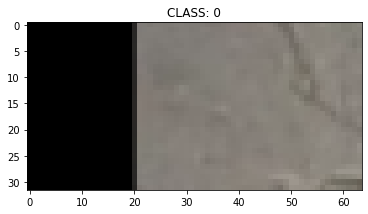

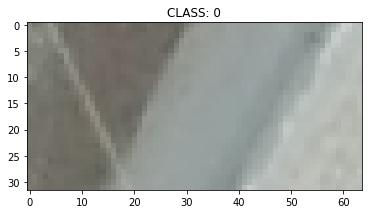

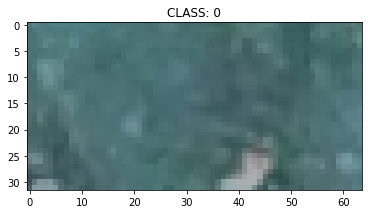

In [72]:
val_img = aerialCarsImageLoader.load_image(
            '../../data/interim/aerial-cars-dataset/val/DJI_0007.JPG',
            '../../data/interim/aerial-cars-dataset/val/DJI_0007.txt'
            )

for bnd in val_img.bnd_boxes:
    car = val_img.get_car(bnd)
    features = get_features(car)
    plt.imshow(car)
    plt.title('CLASS: '+str(clf.predict([features])[0]))
    plt.show()

for i in range(10):
    car = val_img.get_random_box(32, 64)
    features = get_features(car)
    plt.imshow(car)
    plt.title('CLASS: '+str(clf.predict([features])[0]))
    plt.show()

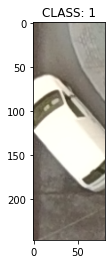

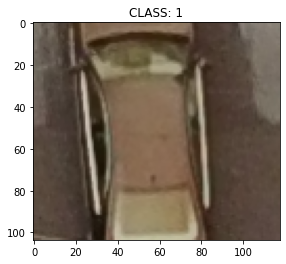

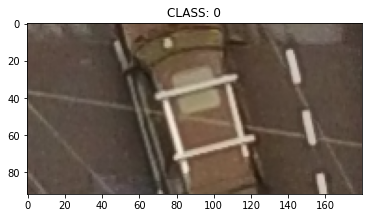

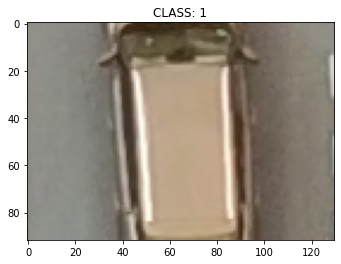

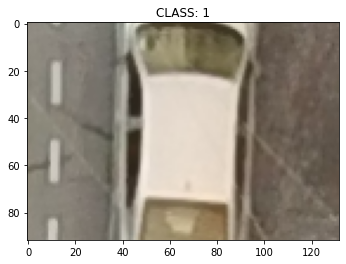

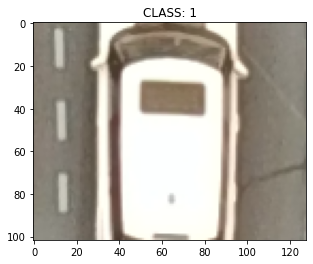

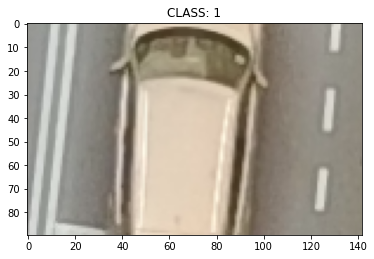

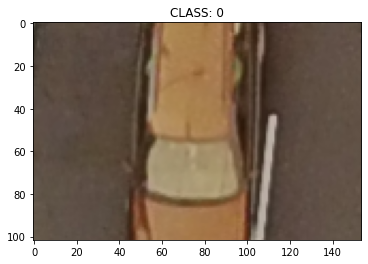

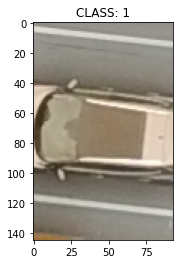

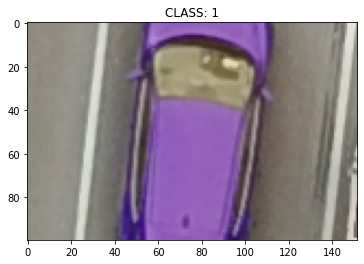

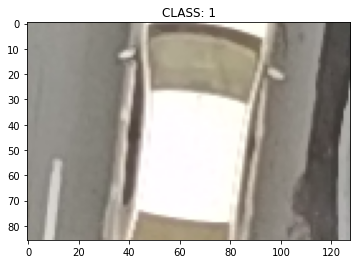

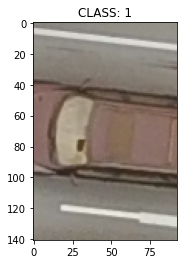

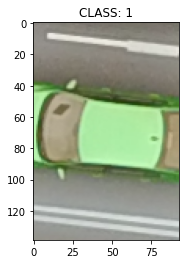

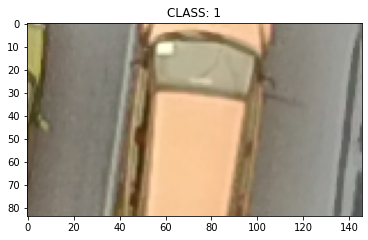

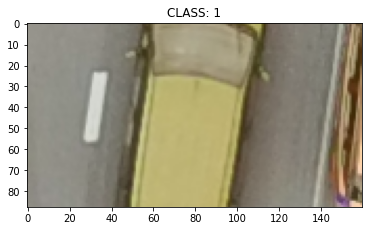

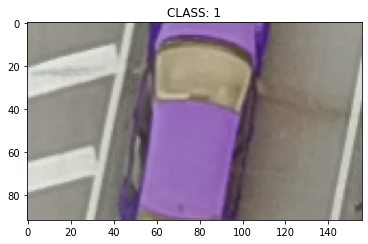

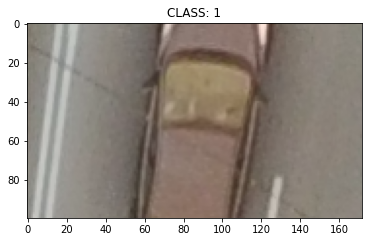

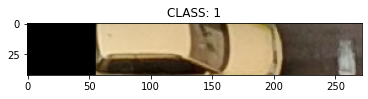

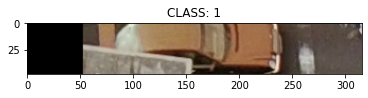

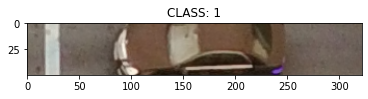

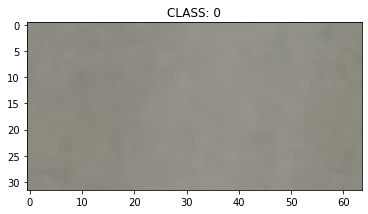

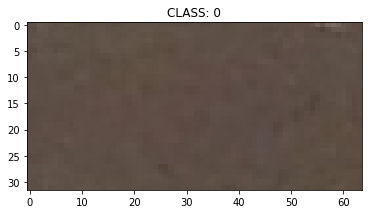

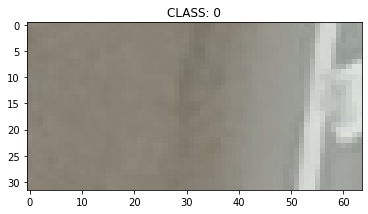

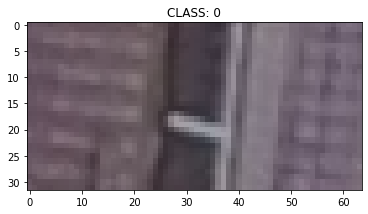

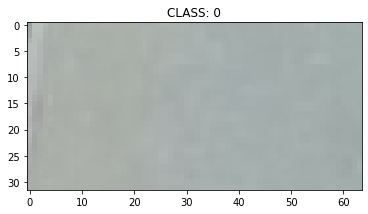

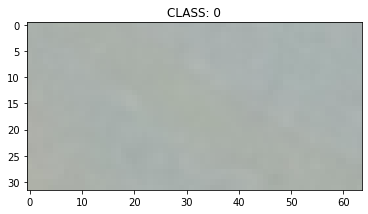

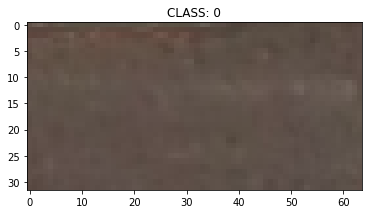

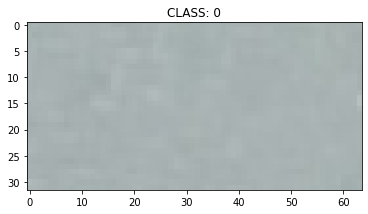

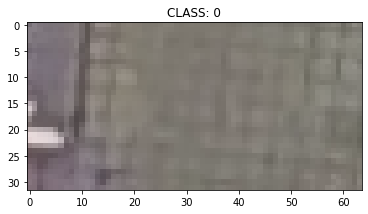

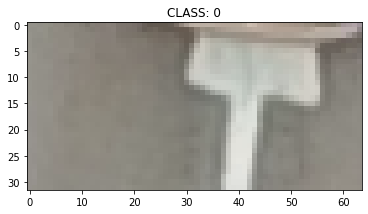

In [76]:
val_img = aerialCarsImageLoader.load_image(
            '../../data/interim/aerial-cars-dataset/val/DJI_0009.JPG',
            '../../data/interim/aerial-cars-dataset/val/DJI_0009.txt'
            )

for bnd in val_img.bnd_boxes:
    car = val_img.get_car(bnd)
    features = get_features(car)
    plt.imshow(car)
    plt.title('CLASS: '+str(clf.predict([features])[0]))
    plt.show()

for i in range(10):
    car = val_img.get_random_box(32, 64)
    features = get_features(car)
    plt.imshow(car)
    plt.title('CLASS: '+str(clf.predict([features])[0]))
    plt.show()

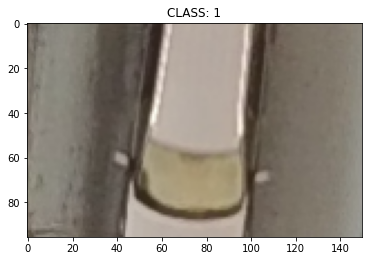

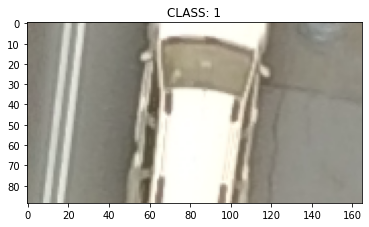

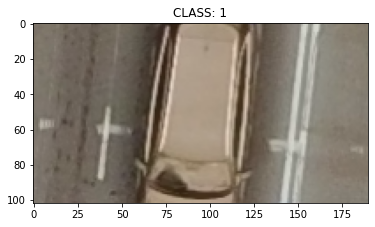

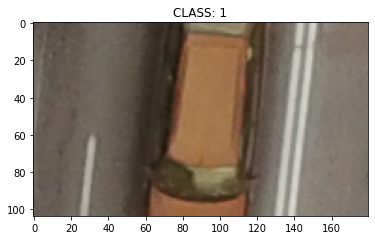

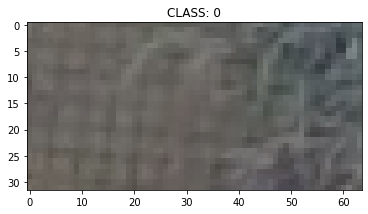

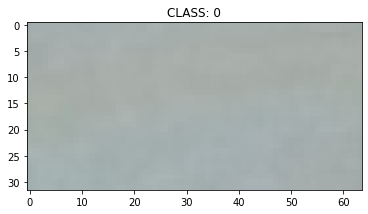

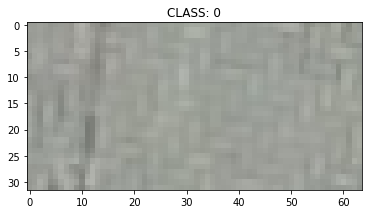

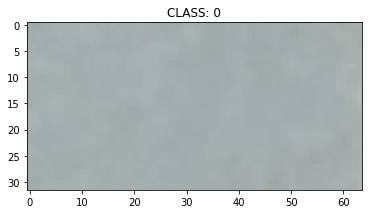

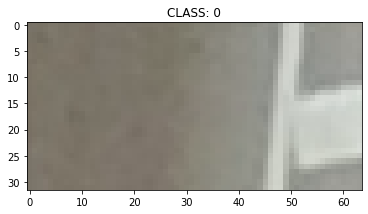

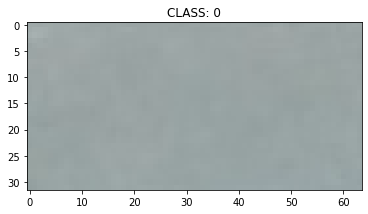

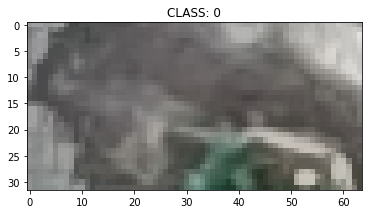

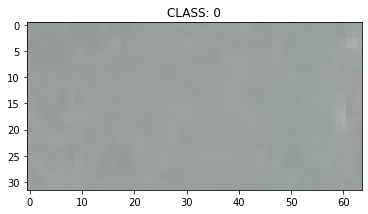

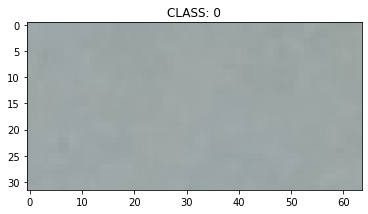

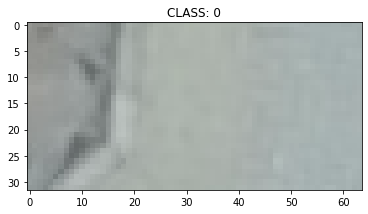

In [77]:
val_img = aerialCarsImageLoader.load_image(
            '../../data/interim/aerial-cars-dataset/val/DJI_0012.JPG',
            '../../data/interim/aerial-cars-dataset/val/DJI_0012.txt'
            )

for bnd in val_img.bnd_boxes:
    car = val_img.get_car(bnd)
    features = get_features(car)
    plt.imshow(car)
    plt.title('CLASS: '+str(clf.predict([features])[0]))
    plt.show()

for i in range(10):
    car = val_img.get_random_box(32, 64)
    features = get_features(car)
    plt.imshow(car)
    plt.title('CLASS: '+str(clf.predict([features])[0]))
    plt.show()

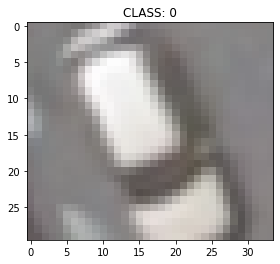

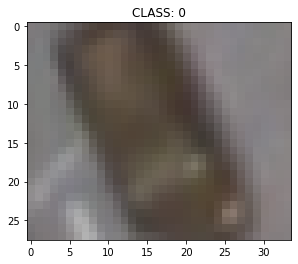

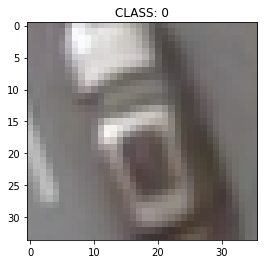

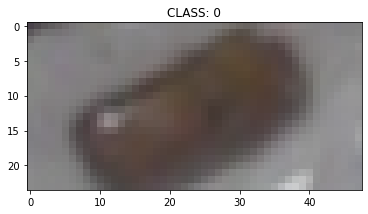

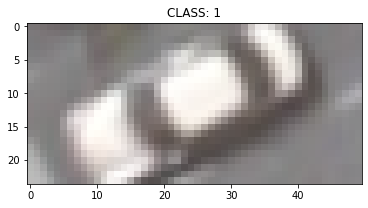

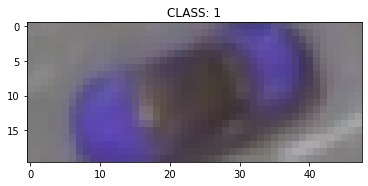

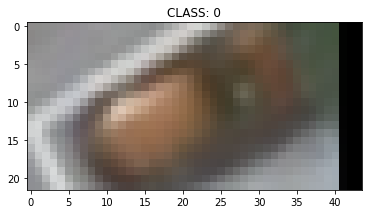

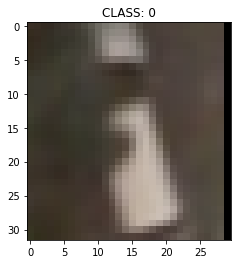

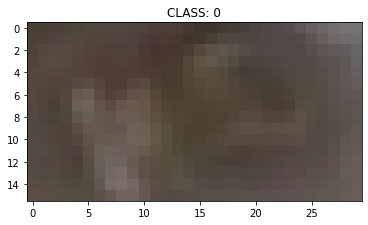

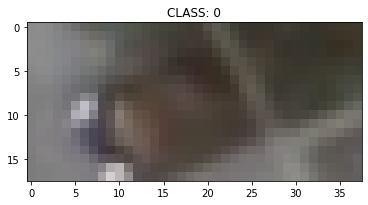

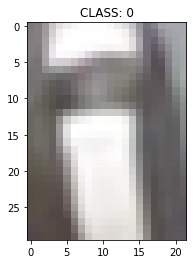

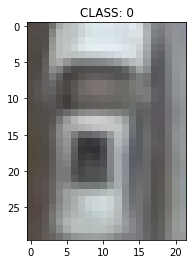

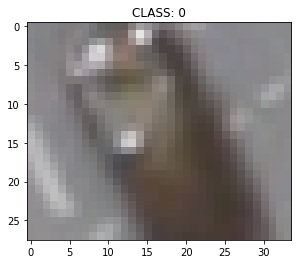

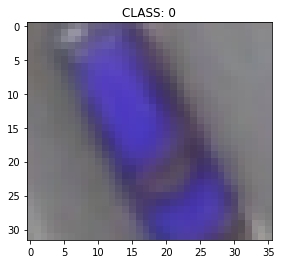

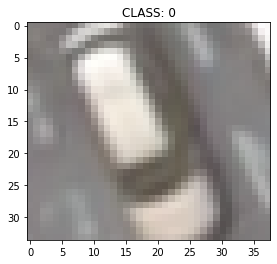

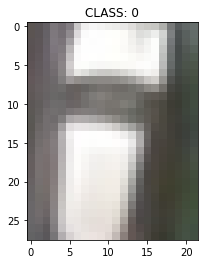

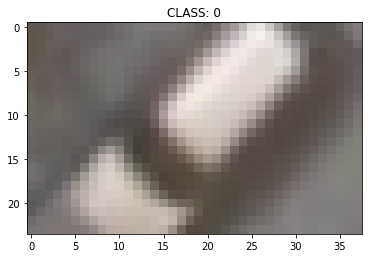

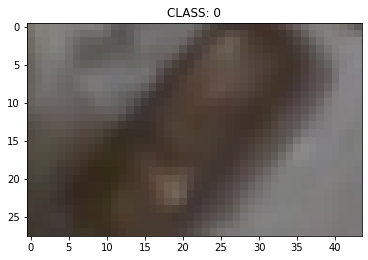

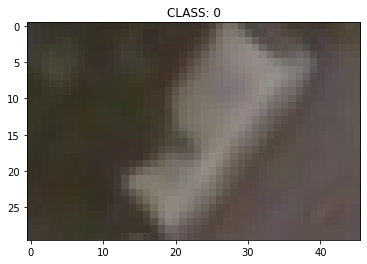

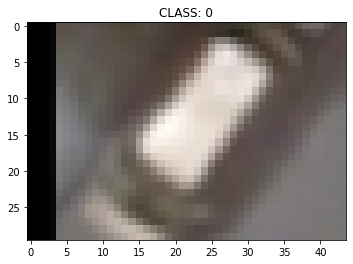

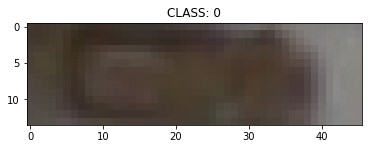

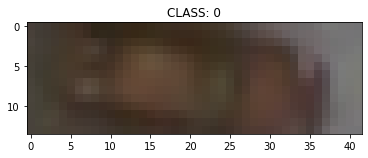

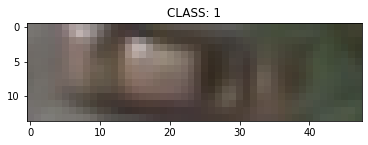

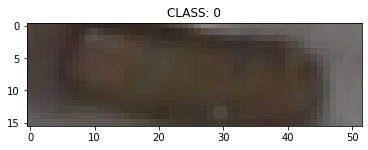

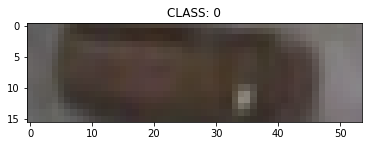

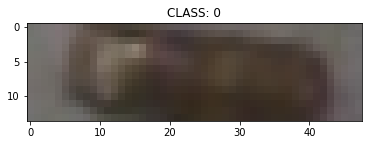

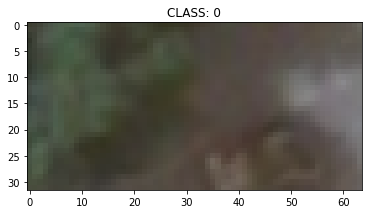

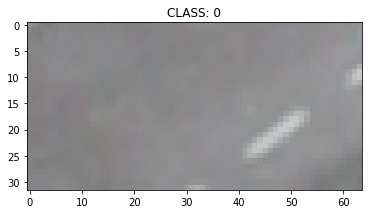

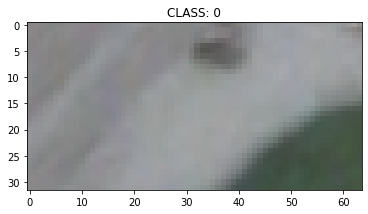

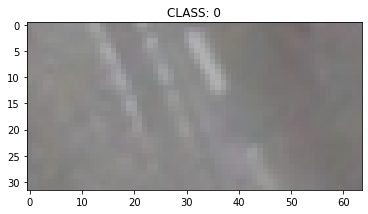

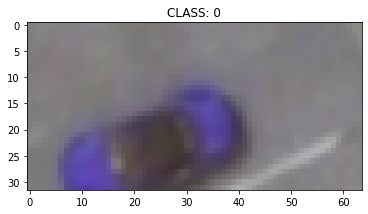

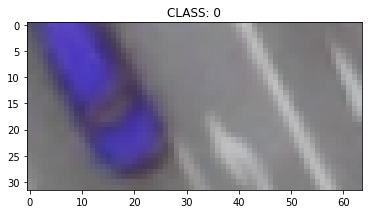

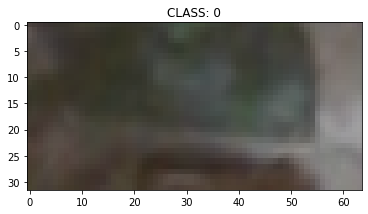

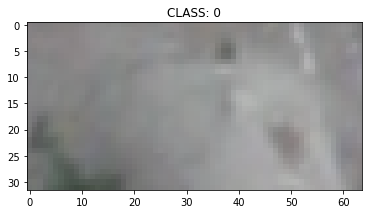

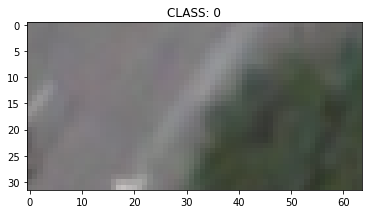

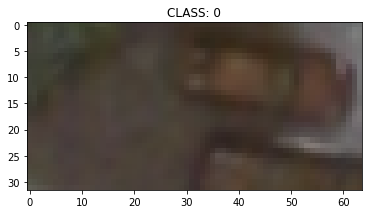

In [78]:
DATA_DIR = '../../data/interim/aerial-cars-dataset/val/'

val_img = aerialCarsImageLoader.load_image(
            '../../data/interim/aerial-cars-dataset/val/MOS88.png',
            '../../data/interim/aerial-cars-dataset/val/MOS88.txt'
            )

for bnd in val_img.bnd_boxes:
    car = val_img.get_car(bnd)
    features = get_features(car)
    plt.imshow(car)
    plt.title('CLASS: '+str(clf.predict([features])[0]))
    plt.show()

for i in range(10):
    car = val_img.get_random_box(32, 64)
    features = get_features(car)
    plt.imshow(car)
    plt.title('CLASS: '+str(clf.predict([features])[0]))
    plt.show()